In [1]:
import pandas as pd
import numpy as np
import sqlite3
from statistics import mean, stdev
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bootstrap_and_compare_function import*

In [2]:
# Connecting to the database, who_suicide, which has 3 tables: 

conn=sqlite3.connect("/Users/flatironschool/Desktop/who_suicide.db")
c=conn.cursor()

# suicide_rate
#     Country
#     Year
#     15-29 years 
#     35-50 years

    # (Observations are divided into male, female, and both sexes(btsx), the year is always 2016)
    
# human_resources
#     Country
#     Year
#     Psychologists working in mental health sector (per 100 000 population)
#     Nurses working in mental health sector (per 100 000 population)
#     Social workers working in mental health sector (per 100 000 population)
#     Psychiatrists working in mental health sector (per 100 000 population)

# facilities
#     Country
#     Year
#     Mental hospitals (per 100 000 population)
#     Mental health units in general hospitals (per 100 000 population)
#     Mental health outpatient facilities (per 100 000 population)
#     Mental health day treatment facilities (per 100 000 population)
#     Community residential facilities (per 100 000 population


In [3]:
# Finding out the mean values of the columns in the human_resources table so we can fill in nulls

df_with_nulls = pd.read_sql_query("""SELECT
                          Country,
                          CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) AS Psychologists,
                          CAST([Nurses working in mental health sector (per 100 000 population)] AS float) AS Nurses,
                          CAST([Social workers working in mental health sector (per 100 000 population)] AS float) AS Social_Workers,
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float) AS Psychiatrists,
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources;""", con=conn)

df_with_nulls.describe()

,Psychologists,Nurses,Social_Workers,Psychiatrists,total_mh_personnel
count,154.000000,154.000000,154.000000,154.000000,154.000000
mean,9.704578,12.663916,3.364045,4.868208,30.600747
std,29.045814,24.874641,16.266182,8.041757,55.832789
min,0.000000,0.000000,0.000000,0.000000,0.035000
25%,0.013000,0.219500,0.000000,0.130000,1.565750
50%,0.560000,2.593500,0.068000,1.239000,8.025500
75%,3.060250,10.563000,0.643000,5.934250,27.670750
max,222.572000,150.251000,145.400000,48.040000,277.478000


In [4]:
# Using SQL to:
#     fill null values with COALESCE,
#     cast strings as floats so we can sum the columns and get the total of mental health providers per country,
#     select countries with above or below the mean number of mental health providers, 
#     join tables on the country column,
#     and select the number of suicides per country.

df_suicide_rate_btsx_above = pd.read_sql_query("""SELECT Country, CAST([15-29  years] AS float) AS [15-29  years]
                     FROM (SELECT
                          Country,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources 
                          WHERE total_mh_personnel >= 30.601)
                    LEFT JOIN suicide_rate
                    Using(Country)
                    WHERE Sex = "Both sexes";""", con=conn)

df_suicide_rate_btsx_below = pd.read_sql_query("""SELECT Country, CAST([15-29  years] AS float) AS [15-29  years]
                     FROM (SELECT
                          Country,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources 
                          WHERE total_mh_personnel < 30.601)
                    LEFT JOIN suicide_rate
                    Using(Country)
                    WHERE Sex = "Both sexes";""", con=conn)

df_suicide_rate_male_above = pd.read_sql_query("""SELECT Country, CAST([15-29  years] AS float) AS [15-29  years]
                     FROM (SELECT
                          Country,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources 
                          WHERE total_mh_personnel >= 30.601)
                    LEFT JOIN suicide_rate
                    Using(Country)
                    WHERE Sex = "Male";""", con=conn)

df_suicide_rate_male_below = pd.read_sql_query("""SELECT Country, CAST([15-29  years] AS float) AS [15-29  years]
                     FROM (SELECT
                          Country,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources 
                          WHERE total_mh_personnel < 30.601)
                    LEFT JOIN suicide_rate
                    Using(Country)
                    WHERE Sex = "Male";""", con=conn)

df_suicide_rate_female_above = pd.read_sql_query("""SELECT Country, CAST([15-29  years] AS float) AS [15-29  years]
                     FROM (SELECT
                          Country,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources 
                          WHERE total_mh_personnel >= 30.601)
                    LEFT JOIN suicide_rate
                    Using(Country)
                    WHERE Sex = "Female";""", con=conn)

df_suicide_rate_female_below = pd.read_sql_query("""SELECT Country, CAST([15-29  years] AS float) AS [15-29  years]
                     FROM (SELECT
                          Country,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources 
                          WHERE total_mh_personnel < 30.601)
                    LEFT JOIN suicide_rate
                    Using(Country)
                    WHERE Sex = "Female";""", con=conn)


# Does availability of mental health providers improve mental health outcomes?

### Alternative Hypothesis 1:

There is a difference in suicide rates for countries below and above the mean threshold of mental health providers per 100,000 people ages 15-29

H0: There is no difference

Note: mental health providers include psychiatrists, psychologists, dedicated mental health nurses, social workers

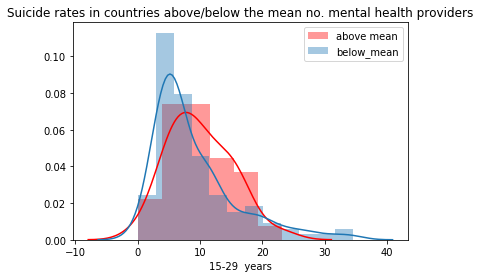

In [5]:
# The distributions of suicides in countries with above average vs. below average number of providers are not normal.
# Also, our "above average" group is small.
# Hence, we decided to bootstrap samples and create a sampling distribution to compare the populations


sns.distplot(df_suicide_rate_btsx_above["15-29  years"], color='red', label="above mean")
sns.distplot(df_suicide_rate_btsx_below["15-29  years"], label="below_mean")
plt.title("Suicide rates in countries above/below the mean no. mental health providers")
plt.legend()

### T TEST: 2 independent samples

With p=0.0, we can reject the Null Hypothesis. These populations are different.


Ttest_indResult(statistic=77.61605928760915, pvalue=0.0)

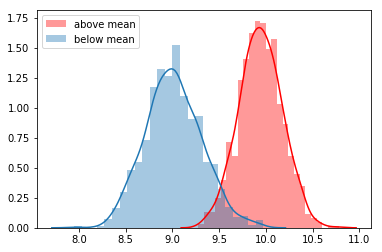

In [6]:
# "bootstrap_and_compare" is a function that does the following:
#     randomly selects values from one of our original samples to create bootstrapped samples
#     gets the mean of each sample
#     does the same for the second original sample
#     does a Welch's t test
#     states the p value and whether it's significant at alpha=0.5
#     plots the means of the bootstrapped samples to show the sampling distributions

samp1=df_suicide_rate_btsx_above["15-29  years"]
samp2=df_suicide_rate_btsx_below["15-29  years"]
bootstrap_and_compare(samp1, samp2, num_bootstraps=1000, size_bootstraps=500)

In [7]:
effect_size = (mean(samp1) - mean(samp2)) / (sqrt((stdev(samp1) ** 2 + stdev(samp2) ** 2) / 2))

print("Effect size:", effect_size)

Effect size: 0.15328557489069433


# Do we get different results when we look at the outcomes for males only? 

### Alternative Hypothesis 2

There is a difference in suicide rates for males in countries below and above the mean threshold of mental health providers per 100,000 for people ages 15-29

H0: There is no difference

35
114


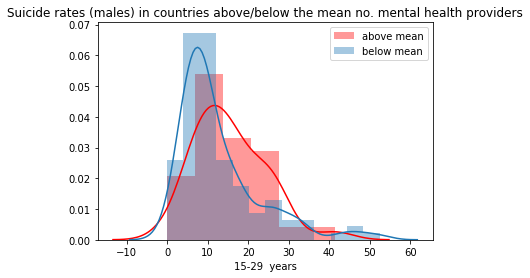

In [8]:
# After looking at the distributions, we again decided to bootstrap samples and create a sampling distribution to compare the populations

print(len(df_suicide_rate_male_above))
print(len(df_suicide_rate_male_below))

sns.distplot(df_suicide_rate_male_above["15-29  years"], color='red', label="above mean")
sns.distplot(df_suicide_rate_male_below["15-29  years"], label='below mean')
plt.title("Suicide rates (males) in countries above/below the mean no. mental health providers")
plt.legend()

### T TEST: 2 independent samples

With p=0.0, we can reject the Null Hypothesis. These populations are different.


Ttest_indResult(statistic=140.66505840796032, pvalue=0.0)

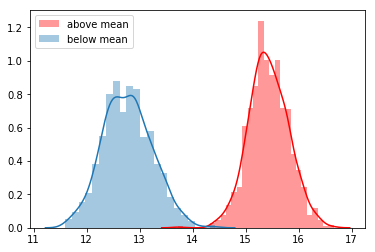

In [9]:
samp1=df_suicide_rate_male_above["15-29  years"]
samp2=df_suicide_rate_male_below["15-29  years"]
bootstrap_and_compare(samp1, samp2, num_bootstraps=1000, size_bootstraps=500)

In [10]:
effect_size = (mean(samp1) - mean(samp2)) / (sqrt((stdev(samp1) ** 2 + stdev(samp2) ** 2) / 2))

print("Effect size:", effect_size)

Effect size: 0.28373686568030676


# Do we get different results when we look at the outcomes for females only?

### Alternative Hypothesis 3

There is a difference in suicide rates for females in countries below and above the mean threshold of mental health professionals per 100,000 for people ages 15-29

H0: There is no difference

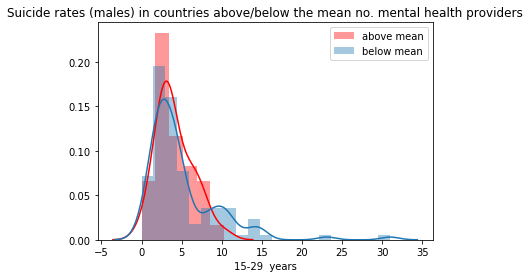

In [11]:
# Same here. We can't tell much from these distributions

sns.distplot(df_suicide_rate_female_above["15-29  years"], color='red', label="above mean")
sns.distplot(df_suicide_rate_female_below["15-29  years"], label="below mean")
plt.title("Suicide rates (males) in countries above/below the mean no. mental health providers")
plt.legend()

### T TEST: 2 independent samples

With p=0.0, we can reject the Null Hypothesis. These populations are different.


Ttest_indResult(statistic=-136.3013504410771, pvalue=0.0)

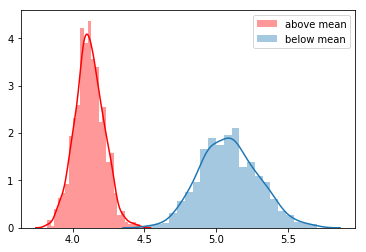

In [12]:
samp1=df_suicide_rate_female_above["15-29  years"]
samp2=df_suicide_rate_female_below["15-29  years"]
bootstrap_and_compare(samp1, samp2, num_bootstraps=1000, size_bootstraps=500)

In [13]:
effect_size = (mean(samp1) - mean(samp2)) / (sqrt((stdev(samp1) ** 2 + stdev(samp2) ** 2) / 2))

print("Effect size:", effect_size)

Effect size: -0.26564335647727033


# ANOVA?

In [49]:
# getting the quantiles of total_mh_personnel so we can break the populations up into groups

df = pd.read_sql_query("""SELECT
                          Country,
                          CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) AS Psychologists,
                          CAST([Nurses working in mental health sector (per 100 000 population)] AS float) AS Nurses,
                          CAST([Social workers working in mental health sector (per 100 000 population)] AS float) AS Social_Workers,
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float) AS Psychiatrists,
                          COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                          COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                          COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                          COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                          CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                          + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                          FROM human_resources ;""", con=conn)


In [50]:
df.describe()

,Psychologists,Nurses,Social_Workers,Psychiatrists,total_mh_personnel
count,154.000000,154.000000,154.000000,154.000000,154.000000
mean,9.704578,12.663916,3.364045,4.868208,30.600747
std,29.045814,24.874641,16.266182,8.041757,55.832789
min,0.000000,0.000000,0.000000,0.000000,0.035000
25%,0.013000,0.219500,0.000000,0.130000,1.565750
50%,0.560000,2.593500,0.068000,1.239000,8.025500
75%,3.060250,10.563000,0.643000,5.934250,27.670750
max,222.572000,150.251000,145.400000,48.040000,277.478000


In [58]:
# making a dataframe with a resources_quantile column

df = pd.read_sql_query("""SELECT Country, [15-29  years] as suicide_rate_per_100_000,
                            CASE 
                              WHEN total_mh_personnel <= 1.57
                                  THEN 0
                              WHEN (total_mh_personnel > 1.57) AND (total_mh_personnel <= 8.03)
                                  THEN 1
                              WHEN (total_mh_personnel > 8.03) AND (total_mh_personnel <= 27.67)
                                  THEN 2
                              ELSE 3
                            END AS resources_quantile
                          FROM (SELECT Country,
                               CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) AS Psychologists,
                               CAST([Nurses working in mental health sector (per 100 000 population)] AS float) AS Nurses,
                               CAST([Social workers working in mental health sector (per 100 000 population)] AS float) AS Social_Workers,
                               CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float) AS Psychiatrists,
                               COALESCE([Psychologists working in mental health sector (per 100 000 population)], 9.705),
                               COALESCE([Nurses working in mental health sector (per 100 000 population)], 12.664),
                               COALESCE([Social workers working in mental health sector (per 100 000 population)], 3.364),
                               COALESCE([Psychiatrists working in mental health sector (per 100 000 population)], 4.868),
                               CAST([Psychiatrists working in mental health sector (per 100 000 population)] AS float)
                               + CAST([Nurses working in mental health sector (per 100 000 population)] AS float)
                               + CAST([Social workers working in mental health sector (per 100 000 population)] AS float)
                               + CAST([Psychologists working in mental health sector (per 100 000 population)] AS float) as total_mh_personnel
                               FROM human_resources) 
                            LEFT JOIN suicide_rate
                            USING(Country)
                            WHERE Sex = "Both sexes";""", con=conn)

                          

In [59]:
# df = df.drop([0,1,2,4,9], axis=0)
# df.head(10)

0    39
3    37
2    37
1    36
Name: resources_quantile, dtype: int64

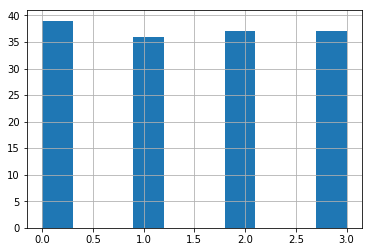

In [60]:
df.resources_quantile.hist()
df.resources_quantile.value_counts()

In [61]:
# making a df with yes/no for stand alone mental health law

gov = pd.read_csv("/Users/flatironschool/Desktop/Kelly/mental_health_governance.csv")
gov = gov[['Country', 'Stand-alone law for mental health']]
gov.set_index('Country', inplace=True)
df.set_index('Country', inplace=True)

In [62]:
df = df.merge(gov, on='Country')

In [46]:
df['Stand-alone law for mental health'].where(df['Stand-alone law for mental health']!='Yes', 1, inplace=True)
df['Stand-alone law for mental health'].where(df['Stand-alone law for mental health']!='No', 0, inplace=True)

In [63]:
df.head()

,suicide_rate_per_100_000,resources_quantile,Stand-alone law for mental health
Country,,,
Afghanistan,8.4,0,Yes
Afghanistan,8.4,0,Yes
Albania,6.9,2,Yes
Albania,6.9,2,Yes
Angola,5.8,0,No


In [23]:

S = 'suicide_rate_per_100_000'
F1 = 'resources_quantile'
F2 = 'Stand-alone law for mental health'
data = df

formula = 'S ~ C(F1)'

sm.tools.tools.add_constant(data)
lm = ols(formula, data).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


PatsyError: Number of rows mismatch between data argument and S (277 versus 1)
    S ~ C(F1)
    ^